<a href="https://colab.research.google.com/github/Alvin-Ruto/TIME-SERIES-FORECASTING-/blob/main/3_time_series_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Analysis, Time Series Forecasting, and Neural Networks

| Key              | Value                                                                                                                                                                                                                                                                                                            |
|:-----------------|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Course Codes** | BBT 4206 and BFS 4102                                                                                                                                                                                                                                                                                            |
| **Course Names** | BBT 4206: Business Intelligence II (Week 7-9 of 13)<br>BFS 4102: Advanced Business Data Analytics (Week 7-9 of 13)                                                                                                                                                                                               |
| **Semester**     | August to November 2025                                                                                                                                                                                                                                                                                          |
| **Lecturer**     | Allan Omondi                                                                                                                                                                                                                                                                                                     |
| **Contact**      | aomondi@strathmore.edu                                                                                                                                                                                                                                                                                           |
| **Note**         | The lecture contains both theory and practice.<br/>This notebook forms part of the practice.<br/>It is intended for educational purposes only.<br/>Recommended citation: [BibTex](https://raw.githubusercontent.com/course-files/TimeSeriesForecastingandNeuralNetworks/refs/heads/main/RecommendedCitation.bib) |


## Stationarity in Time Series

### In-Built Stationarizing Mechanism in Time Series Forecasting Algorithms
1. **❌Exponential Smoothing (Simple, Double [Holt], and Triple [Holt-Winters])**
- Exponential Smoothing techniques do not require the series to be stationary.
- Instead, they explicitly model components such as trend and seasonality directly.
- They handle non-stationarity by design, rather than transforming the data to a stationary form.

2. **✅ARIMA (AutoRegressive Integrated Moving Average)**
- ARIMA explicitly includes differencing (the "I" in ARIMA) as part of the model to make the series stationary.
- You specify the `d` parameter in `ARIMA(p, d, q)`, where:
  - `d = 1` tells the model to difference the data once. This step transforms a non-stationary series into a stationary one internally.

3. **✅SARIMA (Seasonal ARIMA)**
- SARIMA extends ARIMA with seasonal differencing.
- It uses two differencing parameters:
  - `d` for non-seasonal differencing,
  - `D` for seasonal differencing over a defined period m.
- Therefore, SARIMA also has built-in mechanisms to induce both stationarity and seasonal stationarity.

4. **❌LSTM (Long Short-Term Memory Networks)**
- LSTM models do not have explicit stationarizing mechanisms.
- They learn directly from raw sequences, even if they are non-stationary.
- However, data preprocessing such as normalization and differencing often improves performance.
- LSTMs can model complex non-linear and non-stationary behavior, but they do not automatically make the data stationary.

## Step 1: Import Libraries

In [8]:
# For file and system operations
import urllib.request
import os

# For data download
import yfinance as yf

# For time series analysis
import pandas as pd
import numpy as np
from pandas.tseries.offsets import BDay
import re
import pandas_datareader as pdr
import datetime as dt
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression

# For data visualization
import matplotlib.pyplot as plt
import mplfinance as mpf

# For time series forecasting
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

## For time series forecasting with LSTM
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# For suppressing warnings
import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

# Ensures that matplotlib plots are displayed directly within the notebook,
# right below the code cell that produces them. It makes visualizations appear
# inline for easier viewing and analysis.
%matplotlib inline

In [9]:
import pandas as pd
from pandas.tseries.offsets import BDay

df = pd.read_csv("/content/data/my_stock_msft.csv", parse_dates=["Date"])
df = df.sort_values("Date").set_index("Date").asfreq("B").ffill()
y = df["Close"]  # target series


## Baseline Forecast: Holt-Winters Exponential Smoothing


In [22]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Daily equities often show weak weekly seasonality (~5 business days)
model = ExponentialSmoothing(
    y, trend="add", seasonal="mul", seasonal_periods=5
)
fit = model.fit(optimized=True)

h = 63  # 63 business days
future_index = pd.date_range(y.index[-1] + BDay(1), periods=h, freq=BDay())
forecast = pd.Series(fit.forecast(h), index=future_index, name="close_hw")

# required Baseline deliverable:
out = forecast.rename("close_hw").to_frame()
out.index.name = "date"
# Remove timezone and format dates for Power BI
out.index = pd.to_datetime(out.index, utc=True).tz_localize(None)
out = out.reset_index()
out['date'] = pd.to_datetime(out['date']).dt.strftime('%Y-%m-%d')
out.to_csv("data/forecast_basic.csv", index=False)
print("Wrote data/forecast_basic.csv", out.shape)
print("Columns:", list(out.columns))


Wrote data/forecast_basic.csv (63, 2)
Columns: ['date', 'close_hw']


## Intermediate Forecast: SARIMA Model


In [30]:

import warnings, itertools, time
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore")

# y: your training series (Close) with a DatetimeIndex of business days
# future_index: the next 63 business days (already computed earlier)

print("Fitting SARIMA model (compact grid search)…")

# Light search space (fast & robust for stock data)
p_vals, d_vals, q_vals   = [0,1,2], [1], [0,1,2]
P_vals, D_vals, Q_vals   = [0,1],  [1], [0,1]
m_vals                   = [5, 21]   # ~weekly (5 BDays) and trading month (~21 BDays)

best_aic = np.inf
best_cfg = None
best_res = None
t0 = time.time()

for order in itertools.product(p_vals, d_vals, q_vals):
    for seas in itertools.product(P_vals, D_vals, Q_vals, m_vals):
        try:
            res = SARIMAX(
                y,
                order=order,
                seasonal_order=(*seas,),
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit(disp=False)
            aic = res.aic
            if np.isfinite(aic) and aic < best_aic:
                best_aic, best_cfg, best_res = aic, (order, seas), res
        except Exception:
            # ignore non-convergent/invalid combos
            pass

# Fallback in the unlikely event nothing fit
if best_res is None:
    best_cfg = ((1,1,1), (1,1,1,21))
    best_res = SARIMAX(
        y, order=best_cfg[0], seasonal_order=best_cfg[1],
        enforce_stationarity=False, enforce_invertibility=False
    ).fit(disp=False)
    best_aic = best_res.aic

print(f"Selected SARIMA order: {best_cfg[0]}")
print(f"Selected seasonal order: {best_cfg[1]}")
print(f"AIC: {best_aic:.2f} | fit time: {time.time()-t0:.1f}s")

# Forecast 63 business days
sarima_forecast = pd.Series(
    best_res.forecast(len(future_index)),
    index=future_index,
    name="close_sarima"
)

print(f"SARIMA forecast completed: {len(sarima_forecast)} steps")

Fitting SARIMA model (compact grid search)…
Selected SARIMA order: (0, 1, 2)
Selected seasonal order: (0, 1, 1, 21)
AIC: 15408.50 | fit time: 304.2s
SARIMA forecast completed: 63 steps


## Save Intermediate Forecast CSV


In [23]:
# Combined Holt-Winters and SARIMA forecasts
# Note: 'forecast' is the Holt-Winters Series from the baseline cell (already has name='close_hw')
hw_series = forecast.copy()  # forecast already has name='close_hw' from baseline cell
intermediate = pd.concat([hw_series, sarima_forecast], axis=1)
intermediate.index.name = 'date'

# Removing timezone and formatting dates for Power BI
intermediate.index = pd.to_datetime(intermediate.index, utc=True).tz_localize(None)
intermediate = intermediate.reset_index()
intermediate['date'] = pd.to_datetime(intermediate['date']).dt.strftime('%Y-%m-%d')

# Saving Intermediate deliverable
intermediate.to_csv('data/forecast_intermediate.csv', index=False)
print("Wrote data/forecast_intermediate.csv", intermediate.shape)
print("Columns:", list(intermediate.columns))


Wrote data/forecast_intermediate.csv (63, 3)
Columns: ['date', 'close_hw', 'close_sarima']


## Advanced Forecast: Prophet and LSTM Models


In [24]:
# Prophet model
from prophet import Prophet

# Prepare data for Prophet (requires 'ds' and 'y' columns)
dfp = y.reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})

print("Fitting Prophet model...")
m_prophet = Prophet()
m_prophet.fit(dfp)

# Create future dataframe (calendar days, then filter to business days)
future_prophet = m_prophet.make_future_dataframe(periods=90)  # enough to cover 63 business days
pred_prophet = m_prophet.predict(future_prophet)[['ds', 'yhat']].set_index('ds')

# Align Prophet forecast to business days
pred_prophet.index = pd.to_datetime(pred_prophet.index)
prophet_forecast = pred_prophet.reindex(future_index).dropna()['yhat'].rename('close_prophet')

# If Prophet forecast is shorter,
if len(prophet_forecast) < 63:
    prophet_forecast = prophet_forecast.reindex(future_index, method='ffill')

print(f"Prophet forecast completed: {len(prophet_forecast)} steps")


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting Prophet model...
Prophet forecast completed: 63 steps


### LSTM Model Preparation


In [25]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Scale data
scaler = MinMaxScaler()
ys = scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

# Windowing: create sequences of length 60
win = 60
X, Y = [], []
for i in range(win, len(ys)):
    X.append(ys[i-win:i])
    Y.append(ys[i])
X, Y = np.array(X), np.array(Y)
X = X[..., None]  # (samples, timesteps, features=1)

# Split: 80% train, 20% validation
split = int(len(X) * 0.8)
Xtr, Xval, ytr, yval = X[:split], X[split:], Y[:split], Y[split:]

print(f"Training samples: {len(Xtr)}, Validation samples: {len(Xval)}")


Training samples: 2212, Validation samples: 553


### LSTM Hyperparameter Tuning


In [26]:
# NOTE  Hyperparameter tuning allows us to test different model configurations
# and select the best-performing LSTM architecture for forecasting.

# Check device availability
gpus = tf.config.list_physical_devices('GPU')
device_used = "GPU" if len(gpus) > 0 else "CPU"
print(f"Training on: {device_used}")

# Defined hyperparameter grid
hyperparams = [
    {'units': 32, 'lr': 0.01, 'epochs': 40, 'batch': 16, 'name': 'lstm_32units_lr001'},
    {'units': 64, 'lr': 0.005, 'epochs': 50, 'batch': 32, 'name': 'lstm_64units_lr0005'},
    {'units': 100, 'lr': 0.001, 'epochs': 60, 'batch': 16, 'name': 'lstm_100units_lr0001'}
]

# Store all trained models and their training metrics
lstm_models = {}
training_times = {}
validation_maes = {}

import time
from tensorflow.keras.optimizers import Adam

print("=" * 60)
print("LSTM HYPERPARAMETER TUNING")
print("=" * 60)

for i, params in enumerate(hyperparams, 1):
    print(f"\n[{i}/{len(hyperparams)}] Training LSTM: {params['name']}")
    print(f"   Units: {params['units']}, LR: {params['lr']}, Epochs: {params['epochs']}, Batch: {params['batch']}")

    # Build model
    model = Sequential([
        LSTM(params['units'], activation='tanh', input_shape=(win, 1)),
        Dropout(0.2),
        Dense(1)
    ])

    # Compile with specified learning rate
    model.compile(
        optimizer=Adam(learning_rate=params['lr']),
        loss='mae',
        metrics=['mae']
    )

    # Early stopping callback
    cb = EarlyStopping(
        patience=5,
        restore_best_weights=True,
        monitor='val_loss',
        verbose=0
    )

    # Train model
    start_time = time.time()
    history = model.fit(
        Xtr, ytr,
        validation_data=(Xval, yval),
        epochs=params['epochs'],
        batch_size=params['batch'],
        callbacks=[cb],
        verbose=0  # Suppress output for cleaner notebook
    )
    training_time = time.time() - start_time

    # Store results
    lstm_models[params['name']] = model
    training_times[params['name']] = training_time
    validation_maes[params['name']] = min(history.history['val_mae'])

    print(f"   ✅ Training completed in {training_time:.2f}s ({training_time/60:.2f} min)")
    print(f"   Validation MAE: {validation_maes[params['name']]:.4f}")

print("\n" + "=" * 60)
print("HYPERPARAMETER TUNING SUMMARY")
print("=" * 60)
for name, mae in validation_maes.items():
    print(f"  {name}: MAE={mae:.4f}, Time={training_times[name]:.2f}s")


Training on: CPU
LSTM HYPERPARAMETER TUNING

[1/3] Training LSTM: lstm_32units_lr001
   Units: 32, LR: 0.01, Epochs: 40, Batch: 16
   ✅ Training completed in 15.61s (0.26 min)
   Validation MAE: 0.0076

[2/3] Training LSTM: lstm_64units_lr0005
   Units: 64, LR: 0.005, Epochs: 50, Batch: 32
   ✅ Training completed in 9.95s (0.17 min)
   Validation MAE: 0.0100

[3/3] Training LSTM: lstm_100units_lr0001
   Units: 100, LR: 0.001, Epochs: 60, Batch: 16
   ✅ Training completed in 32.11s (0.54 min)
   Validation MAE: 0.0092

HYPERPARAMETER TUNING SUMMARY
  lstm_32units_lr001: MAE=0.0076, Time=15.61s
  lstm_64units_lr0005: MAE=0.0100, Time=9.95s
  lstm_100units_lr0001: MAE=0.0092, Time=32.11s


### LSTM 63-Day Recursive Forecasts

In [27]:
# NOTE : Generating 63-day forecasts for each LSTM configuration
# using recursive prediction (each step uses previous predictions as input).

# Store all LSTM forecasts
lstm_forecasts = {}

print("Generating 63-day forecasts for all LSTM configurations...")
print("=" * 60)

for name, model in lstm_models.items():
    print(f"\n[{name}] Generating forecast...")

    # Recursive forecast: start with last 60 scaled values
    last = ys[-win:].copy()
    pred_scaled = []

    for step in range(63):
        x = last.reshape(1, win, 1)
        yhat = model.predict(x, verbose=0)[0, 0]
        pred_scaled.append(yhat)
        # Slide window: remove first, append prediction
        last = np.concatenate([last[1:], [yhat]])
        if (step + 1) % 20 == 0:
            print(f"  Step {step + 1}/63...")

    # Inverse transform to original scale
    pred = scaler.inverse_transform(np.array(pred_scaled).reshape(-1, 1)).ravel()

    # Create Series with business day index
    # Column name format: close_lstm_32units_lr001
    col_name = f"close_{name}"
    forecast_series = pd.Series(pred, index=future_index, name=col_name)
    lstm_forecasts[col_name] = forecast_series

    print(f"  ✅ Completed: {len(forecast_series)} steps")
    print(f"  Range: ${forecast_series.min():.2f} - ${forecast_series.max():.2f}")

print("\n" + "=" * 60)
print("All LSTM forecasts completed!")
print(f"Total configurations: {len(lstm_forecasts)}")


Generating 63-day forecasts for all LSTM configurations...

[lstm_32units_lr001] Generating forecast...
  Step 20/63...
  Step 40/63...
  Step 60/63...
  ✅ Completed: 63 steps
  Range: $356.66 - $391.90

[lstm_64units_lr0005] Generating forecast...
  Step 20/63...
  Step 40/63...
  Step 60/63...
  ✅ Completed: 63 steps
  Range: $395.52 - $416.82

[lstm_100units_lr0001] Generating forecast...
  Step 20/63...
  Step 40/63...
  Step 60/63...
  ✅ Completed: 63 steps
  Range: $395.20 - $425.64

All LSTM forecasts completed!
Total configurations: 3


## Save Advanced Forecast CSV


## Model Comparison Metrics Table (Advanced Requirement)

This section computes MAE, RMSE, and sMAPE for all models on a shared validation window using a rolling backtest approach.


In [29]:
# MODEL COMPARISON: HW + SARIMA(statsmodels) + Prophet(optional) + LSTM
import os, warnings, itertools, numpy as np, pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler

# Keras (LSTM)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

warnings.filterwarnings("ignore")

# y must be a pandas Series of Close with a DatetimeIndex (already prepared earlier)
assert isinstance(y.index, pd.DatetimeIndex), "y must be indexed by dates"

# ---------- split: last 63 business days as validation ----------
val_size = 63
train_size = len(y) - val_size
y_train = y.iloc[:train_size]
y_val   = y.iloc[train_size:]

print("=" * 60)
print("MODEL COMPARISON: Validation Window Metrics")
print("=" * 60)
print(f"Training period: {y_train.index[0].date()} to {y_train.index[-1].date()} ({len(y_train)} days)")
print(f"Validation period: {y_val.index[0].date()} to {y_val.index[-1].date()} ({len(y_val)} days)")
print("=" * 60)

# ---------- metrics helpers ----------
def smape(y_true, y_pred):
    num = np.abs(np.array(y_pred) - np.array(y_true))
    den = (np.abs(y_true) + np.abs(y_pred)) / 2
    return 100 * np.mean(num / np.where(den == 0, 1, den))

val_predictions = {}
metrics_dict = {}

# ---------- 1) Holt–Winters ----------
print("\n1️⃣  Fitting Holt-Winters on training data…")
hw_model = ExponentialSmoothing(y_train, trend="add", seasonal="mul", seasonal_periods=5)
hw_fit   = hw_model.fit(optimized=True)
hw_pred  = hw_fit.forecast(val_size)
val_predictions['Holt-Winters'] = hw_pred
metrics_dict['Holt-Winters'] = {
    'MAE':   mean_absolute_error(y_val, hw_pred),
    'RMSE':  np.sqrt(mean_squared_error(y_val, hw_pred)),
    'sMAPE': smape(y_val, hw_pred)
}
print(f"   ✅ MAE: ${metrics_dict['Holt-Winters']['MAE']:.2f}, "
      f"RMSE: ${metrics_dict['Holt-Winters']['RMSE']:.2f}, "
      f"sMAPE: {metrics_dict['Holt-Winters']['sMAPE']:.2f}%")

# ---------- 2) SARIMA (statsmodels grid, no pmdarima) ----------
print("\n2️⃣  Fitting SARIMA on training data…")
p, d, q   = [0,1,2], [1], [0,1,2]
P, D, Q   = [0,1],  [1], [0,1]
m_vals    = [5, 21]  # ~weekly business days, ~trading month

best_aic, best_cfg, best_res = np.inf, None, None
for order in itertools.product(p, d, q):
    for seas in itertools.product(P, D, Q, m_vals):
        try:
            res = SARIMAX(
                y_train, order=order, seasonal_order=(*seas,),
                enforce_stationarity=False, enforce_invertibility=False
            ).fit(disp=False)
            if np.isfinite(res.aic) and res.aic < best_aic:
                best_aic, best_cfg, best_res = res.aic, (order, seas), res
        except Exception:
            pass

if best_res is None:  # safe fallback
    best_cfg = ((1,1,1), (1,1,1,21))
    best_res = SARIMAX(
        y_train, order=best_cfg[0], seasonal_order=best_cfg[1],
        enforce_stationarity=False, enforce_invertibility=False
    ).fit(disp=False)

sarima_pred = best_res.forecast(val_size)
val_predictions['SARIMA'] = sarima_pred
metrics_dict['SARIMA'] = {
    'MAE':   mean_absolute_error(y_val, sarima_pred),
    'RMSE':  np.sqrt(mean_squared_error(y_val, sarima_pred)),
    'sMAPE': smape(y_val, sarima_pred)
}
print(f"   ✅ Best orders: {best_cfg} | "
      f"MAE: ${metrics_dict['SARIMA']['MAE']:.2f}, "
      f"RMSE: ${metrics_dict['SARIMA']['RMSE']:.2f}, "
      f"sMAPE: {metrics_dict['SARIMA']['sMAPE']:.2f}%")

# ---------- 3) Prophet (optional; skip if not installed) ----------
print("\n3️⃣  Fitting Prophet on training data…")
prophet_ok = False
try:
    from prophet import Prophet
    dfp = y_train.reset_index()
    dfp.columns = ['ds', 'y']
    m = Prophet()
    m.fit(dfp)
    # forecast on calendar days then align to business-day validation index
    future_cal = m.make_future_dataframe(periods=val_size+30, freq="D")
    pred = m.predict(future_cal)[['ds','yhat']].set_index('ds')
    pred.index = pd.to_datetime(pred.index)
    ph_pred = pred.reindex(y_val.index)['yhat'].interpolate(limit_direction="both")
    val_predictions['Prophet'] = ph_pred.values
    metrics_dict['Prophet'] = {
        'MAE':   mean_absolute_error(y_val, ph_pred),
        'RMSE':  np.sqrt(mean_squared_error(y_val, ph_pred)),
        'sMAPE': smape(y_val, ph_pred)
    }
    print(f"   ✅ MAE: ${metrics_dict['Prophet']['MAE']:.2f}, "
          f"RMSE: ${metrics_dict['Prophet']['RMSE']:.2f}, "
          f"sMAPE: {metrics_dict['Prophet']['sMAPE']:.2f}%")
    prophet_ok = True
except Exception as e:
    print("   ⚠️ Prophet not available or failed:", e)

# ---------- 4) LSTM (three configs) ----------
print("\n4️⃣  Fitting LSTM models on training data…")
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1,1)).flatten()

win = 60
X_train, Y_train = [], []
for i in range(win, len(y_train_scaled)):
    X_train.append(y_train_scaled[i-win:i])
    Y_train.append(y_train_scaled[i])
X_train = np.array(X_train).reshape(-1, win, 1)
Y_train = np.array(Y_train)

X_seed = y_train_scaled[-win:].reshape(1, win, 1)  # seed for recursive val preds

lstm_configs = [
    {'units': 32,  'lr': 0.01,  'epochs': 40, 'batch': 16, 'name': 'lstm_32_lr001'},
    {'units': 64,  'lr': 0.005, 'epochs': 50, 'batch': 32, 'name': 'lstm_64_lr0005'},
    {'units': 100, 'lr': 0.001, 'epochs': 60, 'batch': 16, 'name': 'lstm_100_lr0001'},
]

for cfg in lstm_configs:
    print(f"   Training {cfg['name']}…")
    model = Sequential([LSTM(cfg['units'], activation='tanh', input_shape=(win,1)),
                        Dropout(0.2),
                        Dense(1)])
    model.compile(optimizer=Adam(learning_rate=cfg['lr']), loss='mae', metrics=['mae'])
    cb = EarlyStopping(patience=5, restore_best_weights=True, monitor='loss', verbose=0)
    model.fit(X_train, Y_train, epochs=cfg['epochs'], batch_size=cfg['batch'], callbacks=[cb], verbose=0)

    # recursive forecast over validation window
    last = X_seed.copy()
    preds_scaled = []
    for _ in range(val_size):
        p = model.predict(last, verbose=0)[0,0]
        preds_scaled.append(p)
        last = np.concatenate([last[:,1:,:], np.array([[[p]]])], axis=1)

    lstm_val = scaler.inverse_transform(np.array(preds_scaled).reshape(-1,1)).ravel()
    name = f"LSTM ({cfg['name']})"
    val_predictions[name] = lstm_val
    metrics_dict[name] = {
        'MAE':   mean_absolute_error(y_val, lstm_val),
        'RMSE':  np.sqrt(mean_squared_error(y_val, lstm_val)),
        'sMAPE': smape(y_val, lstm_val)
    }
    print(f"      ✅ MAE: ${metrics_dict[name]['MAE']:.2f}, "
          f"RMSE: ${metrics_dict[name]['RMSE']:.2f}, "
          f"sMAPE: {metrics_dict[name]['sMAPE']:.2f}%")

# ---------- summary ----------
metrics_df = pd.DataFrame(metrics_dict).T.round(4)
metrics_df.index.name = 'Model'

print("\n" + "=" * 60)
print("MODEL COMPARISON SUMMARY")
print("=" * 60)
print(metrics_df.to_string())
print("=" * 60)

os.makedirs('artifacts', exist_ok=True)
metrics_df.to_csv('artifacts/metrics_summary.csv')
print("\n✅ Saved metrics summary to artifacts/metrics_summary.csv")
print("\nBest model by metric:")
print(f"  MAE:   {metrics_df['MAE'].idxmin()} (${metrics_df['MAE'].min():.2f})")
print(f"  RMSE:  {metrics_df['RMSE'].idxmin()} (${metrics_df['RMSE'].min():.2f})")
print(f"  sMAPE: {metrics_df['sMAPE'].idxmin()} ({metrics_df['sMAPE'].min():.2f}%)")


MODEL COMPARISON: Validation Window Metrics
Training period: 2015-01-02 to 2025-08-04 (2762 days)
Validation period: 2025-08-05 to 2025-10-30 (63 days)

1️⃣  Fitting Holt-Winters on training data…
   ✅ MAE: $3.91, RMSE: $4.53, sMAPE: 0.99%

2️⃣  Fitting SARIMA on training data…


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


   ✅ Best orders: ((0, 1, 2), (0, 1, 1, 21)) | MAE: $4.16, RMSE: $4.78, sMAPE: 1.05%

3️⃣  Fitting Prophet on training data…
   ✅ MAE: $61.23, RMSE: $61.35, sMAPE: 14.44%

4️⃣  Fitting LSTM models on training data…
   Training lstm_32_lr001…
      ✅ MAE: $123.07, RMSE: $152.08, sMAPE: 25.43%
   Training lstm_64_lr0005…
      ✅ MAE: $133.83, RMSE: $151.73, sMAPE: 28.02%
   Training lstm_100_lr0001…
      ✅ MAE: $71.76, RMSE: $80.84, sMAPE: 20.67%

MODEL COMPARISON SUMMARY
                             MAE      RMSE    sMAPE
Model                                              
Holt-Winters              3.9064    4.5266   0.9867
SARIMA                    4.1609    4.7783   1.0506
Prophet                  61.2256   61.3519  14.4386
LSTM (lstm_32_lr001)    123.0653  152.0767  25.4339
LSTM (lstm_64_lr0005)   133.8280  151.7287  28.0240
LSTM (lstm_100_lr0001)   71.7582   80.8440  20.6703

✅ Saved metrics summary to artifacts/metrics_summary.csv

Best model by metric:
  MAE:   Holt-Winters ($3.9

In [32]:
# Combined models: HW + SARIMA + Prophet + All LSTM configurations
# Note: 'forecast' is the Holt-Winters Series from the baseline cell (already has name='close_hw')
hw_series = forecast.copy()  # forecast already has name='close_hw' from baseline cell

# Combine all forecast series
all_forecasts = [hw_series, sarima_forecast, prophet_forecast]
all_forecasts.extend(lstm_forecasts.values())  # Add all LSTM configurations

advanced = pd.concat(all_forecasts, axis=1)

advanced.index.name = 'date'

# Remove timezone and format dates for Power BI
advanced.index = pd.to_datetime(advanced.index, utc=True).tz_localize(None)
advanced = advanced.reset_index()
advanced['date'] = pd.to_datetime(advanced['date']).dt.strftime('%Y-%m-%d')

# Save Advanced deliverable
advanced.to_csv('data/forecast_advanced.csv', index=False)
print("=" * 60)
print("✅ Saved forecast_advanced.csv")
print("=" * 60)
print(f"Shape: {advanced.shape}")
print(f"Columns ({len(advanced.columns)}): {list(advanced.columns)}")
print(f"\nForecast summary:")
print(advanced.describe())


✅ Saved forecast_advanced.csv
Shape: (63, 7)
Columns (7): ['date', 'close_hw', 'close_sarima', 'close_prophet', 'close_lstm_32units_lr001', 'close_lstm_64units_lr0005', 'close_lstm_100units_lr0001']

Forecast summary:
         close_hw  close_sarima  close_prophet  close_lstm_32units_lr001  \
count   63.000000     63.000000      63.000000                 63.000000   
mean   397.214621    397.377779     462.467689                373.650269   
std      2.241169      2.315308       7.426855                 10.607740   
min    393.158280    393.398131     433.475700                356.658997   
25%    395.366543    395.622345     463.527448                364.545135   
50%    397.303041    397.163097     464.361373                373.134003   
75%    399.138158    398.947499     466.340567                382.547958   
max    400.973906    401.133476     471.440358                391.904938   

       close_lstm_64units_lr0005  close_lstm_100units_lr0001  
count                  63.000000  

## Step 2: Load and Preprocess/Clean the Data

### Load the Data

In [33]:
# NOTE (Student): Updated to use my_stock_msft.csv instead of stockprice_cleaned.csv
dataset_path = './data/my_stock_msft.csv'

if not os.path.exists(dataset_path):
    print("❌ Please ensure my_stock_msft.csv exists in the data/ directory.")
    print("   This file should have been created/downloaded earlier.")
else:
    print("✅ Dataset exists locally: my_stock_msft.csv")

data = pd.read_csv(dataset_path, encoding='utf-8', parse_dates=['Date'])


✅ Dataset exists locally: my_stock_msft.csv


### Preprocess/Clean the Data

In [34]:

# NOTE (Student): Robust preprocessing with vectorized string operations
# Fixed TypeError by using Series.str operations instead of map()

import numpy as np
import pandas as pd
from pandas.tseries.offsets import BDay

# === Load CSV ===
# NOTE: If 'data' already exists from previous cell, we'll use it; otherwise load from CSV
if 'data' not in locals() or data.empty:
    dataset_path = './data/my_stock_msft.csv'
    data = pd.read_csv(dataset_path, encoding='utf-8', parse_dates=['Date'])

# 1) Sort, set index, force BUSINESS-day frequency, forward-fill tiny gaps
#    - Works whether 'Date' is a column or already the index
if "Date" in data.columns:
    df_sorted = data.sort_values("Date").set_index("Date")
else:
    # If 'Date' isn't a column, assume it's already the index (or any datetime index)
    if not isinstance(data.index, pd.DatetimeIndex):
        # Best-effort: try common date column names
        for cand in ["date", "DATE", "timestamp", "Timestamp"]:
            if cand in data.columns:
                data[cand] = pd.to_datetime(data[cand], errors="coerce")
                df_sorted = data.set_index(cand).sort_index()
                break
        else:
            # Fallback: keep as-is and sort by index
            df_sorted = data.sort_index()
    else:
        df_sorted = data.sort_index()

data = df_sorted.asfreq("B").ffill()

# 2) Normalize and de-duplicate column names
data.columns = [c.strip() for c in data.columns]
if data.columns.duplicated().any():
    dups = list(data.columns[data.columns.duplicated()])
    print("Dropping duplicate columns:", dups)
    data = data.loc[:, ~data.columns.duplicated()]

# 3) Robust numeric coercion for OHLC and Volume
#    - handles commas, currency symbols, spaces
#    - converts '(123.45)' to '-123.45'

def clean_num_series(s: pd.Series) -> pd.Series:
    """Vectorized cleaning of numeric Series - tolerant to DataFrame input."""
    # If a DataFrame sneaks in (duplicate labels), use first column
    if isinstance(s, pd.DataFrame):
        s = s.iloc[:, 0]
    s = s.astype(str).str.strip()
    # parentheses negatives → -value
    s = s.str.replace(r'^\((.*)\)$', r'-', regex=True)
    # drop currency symbols/letters/spaces/commas
    s = s.str.replace(r'[^0-9\.\-]', '', regex=True)
    # empty strings → NaN
    s = s.replace('', np.nan)
    return pd.to_numeric(s, errors='coerce')

ohlc_cols = [c for c in ["Open", "High", "Low", "Close"] if c in data.columns]
for c in ohlc_cols:
    data[c] = clean_num_series(data[c])

if "Adj Close" in data.columns:
    data["Adj Close"] = clean_num_series(data["Adj Close"])

if "Volume" in data.columns:
    v = data["Volume"].astype(str).str.replace(r'[^0-9]', '', regex=True).replace('', np.nan)
    data["Volume"] = pd.to_numeric(v, errors='coerce')

# 4) Sanity checks and drop rows with missing OHLC
for c in ohlc_cols:
    assert np.issubdtype(data[c].dtype, np.number), f"{c} is not numeric"

if ohlc_cols:
    before = len(data)
    data = data.dropna(subset=ohlc_cols)
    print("Dropped rows with missing OHLC:", before - len(data))

# 5) Target series
y = data["Close"].copy()

# 6) Future business-day index for exactly 63 steps
future_idx = pd.date_range(y.index[-1] + BDay(1), periods=63, freq=BDay())

print("History span:", y.index.min().date(), "→", y.index.max().date())
print("Rows:", len(data), "| Missing OHLC rows dropped:", data.isna().any(axis=1).sum())
print(data[ohlc_cols + (["Volume"] if "Volume" in data.columns else [])].dtypes)


Dropped rows with missing OHLC: 0
History span: 2015-01-02 → 2025-10-30
Rows: 2825 | Missing OHLC rows dropped: 0
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object


### Confirm Cleaned Data

In [35]:
print("\n*1* The number of observations and variables")
display(data.shape)

print("\n*2* The data types:")
display(data.info())


*1* The number of observations and variables


(2825, 6)


*2* The data types:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2825 entries, 2015-01-02 05:00:00 to 2025-10-30 05:00:00
Freq: B
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2825 non-null   float64
 1   High       2825 non-null   float64
 2   Low        2825 non-null   float64
 3   Close      2825 non-null   float64
 4   Adj Close  2825 non-null   float64
 5   Volume     2825 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 154.5 KB


None

In [36]:
print("\n*3* The summary of the numeric columns:")
display(data.describe())

print("\n*4* The whole dataset:")
display(data)

print("\n*5* The first 5 rows in the dataset:")
display(data.head())

print("\n*6* The last 5 rows in the dataset:")
display(data.tail())


*3* The summary of the numeric columns:


,Open,High,Low,Close,Adj Close,Volume
count,2825.000000,2825.000000,2825.000000,2825.000000,2825.000000,2.825000e+03
mean,193.399260,194.846012,190.791370,192.904234,186.715585,3.049861e+08
std,127.613304,128.518945,125.956924,127.141764,127.962673,1.432370e+08
min,40.590000,41.369999,40.230000,40.400002,34.501606,7.164500e+07
25%,65.110001,65.260002,64.750000,64.930000,58.877567,2.203410e+08
50%,162.610001,163.110001,156.000000,161.570007,154.114624,2.720930e+08
75%,287.959991,289.510010,279.429993,280.070007,272.059509,3.624880e+08
max,451.320007,456.160004,449.570007,454.459991,451.976440,1.691640e+09



*4* The whole dataset:


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02 05:00:00,46.660000,47.419998,46.540001,46.759998,39.933060,279139000
2015-01-05 05:00:00,46.369999,46.730000,46.250000,46.330002,39.565830,396739000
2015-01-06 05:00:00,46.380001,46.750000,45.540001,45.650002,38.985104,364479000
2015-01-07 05:00:00,45.980000,46.459999,45.490002,46.230000,39.480442,291141000
2015-01-08 05:00:00,46.750000,47.750000,46.720001,47.590000,40.641865,296452000
...,...,...,...,...,...,...
2025-10-24 05:00:00,392.320007,394.799988,385.540009,393.309998,391.944946,220341000
2025-10-27 05:00:00,392.320007,394.799988,385.540009,393.309998,391.944946,220341000
2025-10-28 05:00:00,392.320007,394.799988,385.540009,393.309998,391.944946,220341000



*5* The first 5 rows in the dataset:


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02 05:00:00,46.660000,47.419998,46.540001,46.759998,39.933060,279139000
2015-01-05 05:00:00,46.369999,46.730000,46.250000,46.330002,39.565830,396739000
2015-01-06 05:00:00,46.380001,46.750000,45.540001,45.650002,38.985104,364479000
2015-01-07 05:00:00,45.980000,46.459999,45.490002,46.230000,39.480442,291141000
2015-01-08 05:00:00,46.750000,47.750000,46.720001,47.590000,40.641865,296452000



*6* The last 5 rows in the dataset:


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2025-10-24 05:00:00,392.320007,394.799988,385.540009,393.309998,391.944946,220341000
2025-10-27 05:00:00,392.320007,394.799988,385.540009,393.309998,391.944946,220341000
2025-10-28 05:00:00,392.320007,394.799988,385.540009,393.309998,391.944946,220341000
2025-10-29 05:00:00,392.320007,394.799988,385.540009,393.309998,391.944946,220341000
2025-10-30 05:00:00,392.320007,394.799988,385.540009,393.309998,391.944946,220341000


## Step 3: Forecast

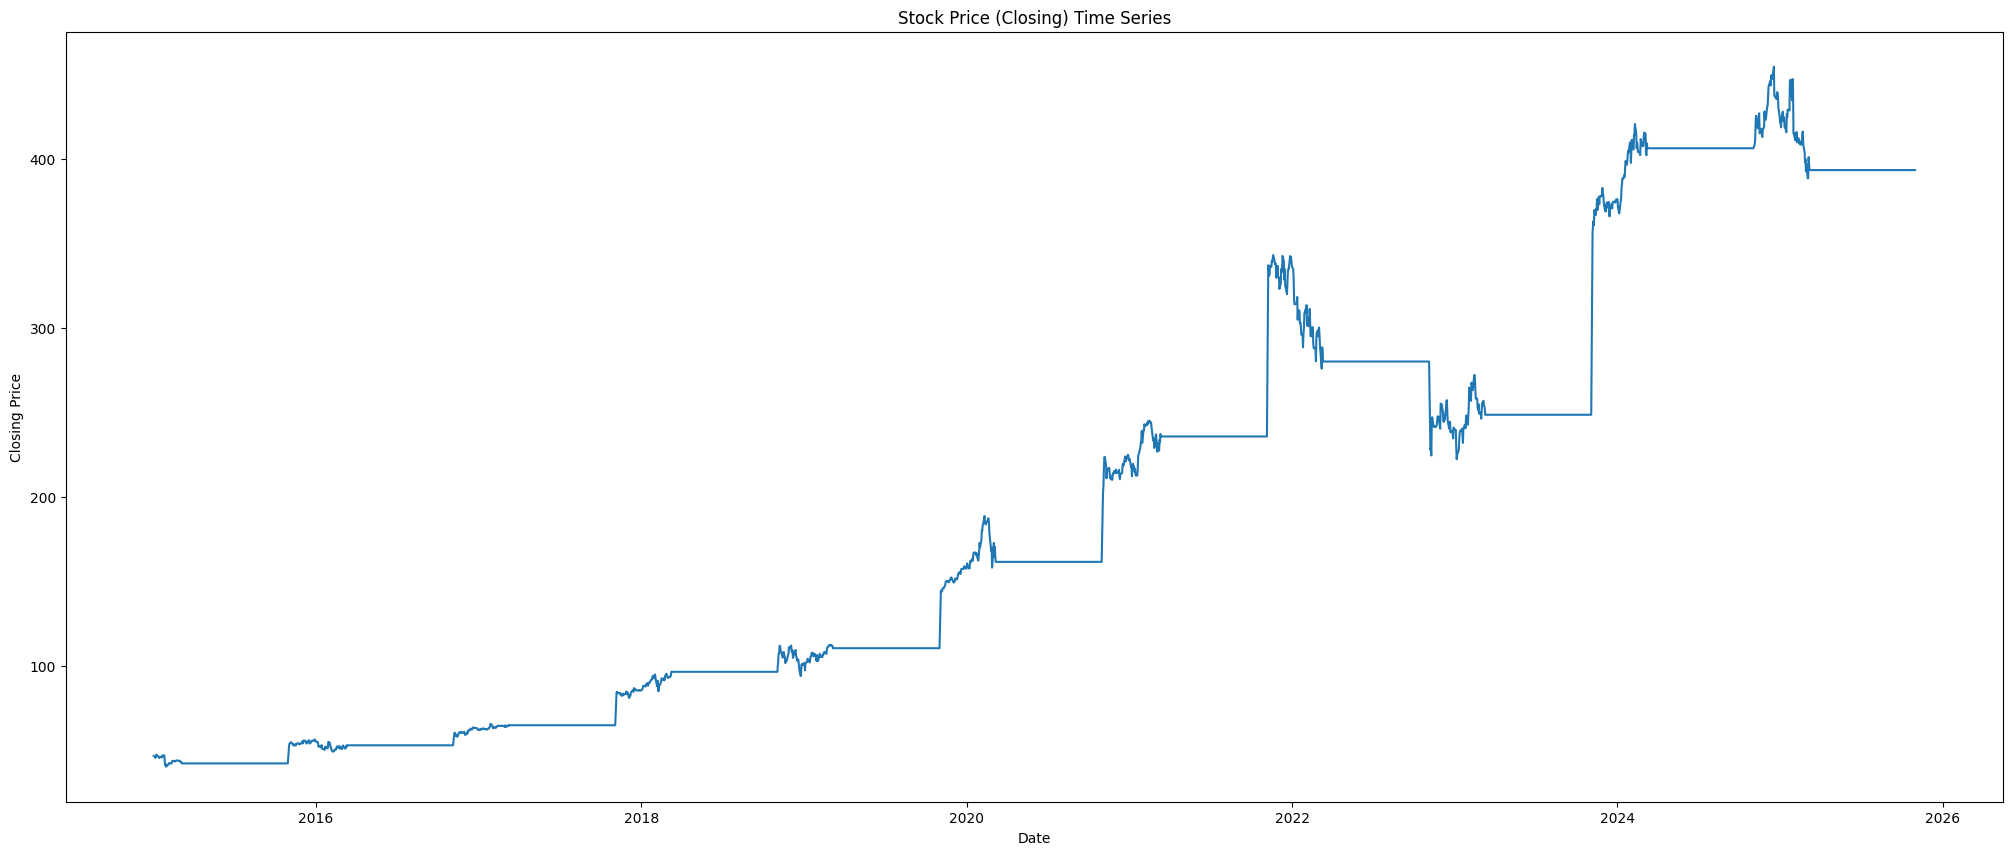

In [37]:
plt.figure(figsize=(25, 10))
plt.plot(data["Close"])
plt.title(f"Stock Price (Closing) Time Series")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.show()

In [38]:
# If data is already a Series, it uses it directly.
# If data is a DataFrame, it selects the Close column and converts it to float64.
ts = data if isinstance(data, pd.Series) else data["Close"].astype('float64')

### Exponential Smoothing

Exponential smoothing is a time series forecasting method for univariate data. It is a weighted average of past observations, with the weights decaying exponentially as the observations get older.

**Note:** Unlike ARIMA models, some exponential smoothing models are designed to handle non-stationary data directly by explicitly modeling trend and seasonality. This is why we can apply them to the original time series.

#### Simple Exponential Smoothing (SES)

- It is normal for Simple Exponential Smoothing (SES) to produce a flat forecast (the same value for all future periods) because it does not model trend or seasonality—only the level. The forecast equals the last estimated level from the fitted model.
- For time series with trend or seasonality, it is better to use Holt’s or Holt-Winters methods instead.

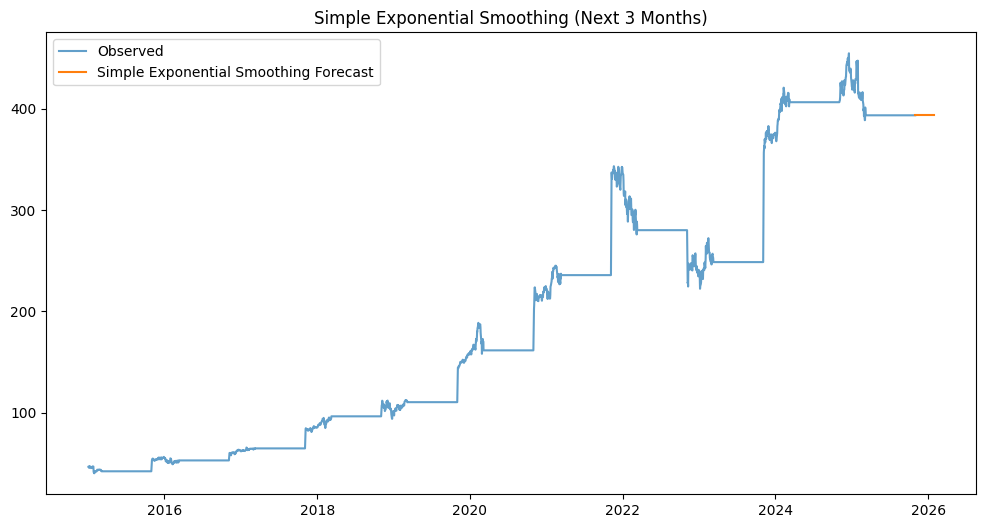

In [39]:
# Fit SES model
model_ses = SimpleExpSmoothing(ts, initialization_method="estimated").fit()

# Forecast next 63 periods
predictions_ses = model_ses.forecast(63)

# Create future index for next 63 periods (e.g., business days)
future_index = pd.date_range(
    start=ts.index[-1] + pd.offsets.BDay(1),
    periods=63,
    freq='B'
)

# Assign index to forecast
predictions_ses = pd.Series(predictions_ses.values, index=future_index)

# Plot observed and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Observed', alpha=0.7)
plt.plot(predictions_ses, label='Simple Exponential Smoothing Forecast')
plt.title('Simple Exponential Smoothing (Next 3 Months)')
plt.legend()
plt.show()

In [40]:
predictions_table = pd.DataFrame(predictions_ses)
display(predictions_table)

,0
2025-10-31 05:00:00,393.309998
2025-11-03 05:00:00,393.309998
2025-11-04 05:00:00,393.309998
2025-11-05 05:00:00,393.309998
2025-11-06 05:00:00,393.309998
...,...
2026-01-21 05:00:00,393.309998
2026-01-22 05:00:00,393.309998
2026-01-23 05:00:00,393.309998
2026-01-26 05:00:00,393.309998


#### Double Exponential Smoothing (Holt's Method)

Holt's method is an extension of SES that can handle time series data with a trend.

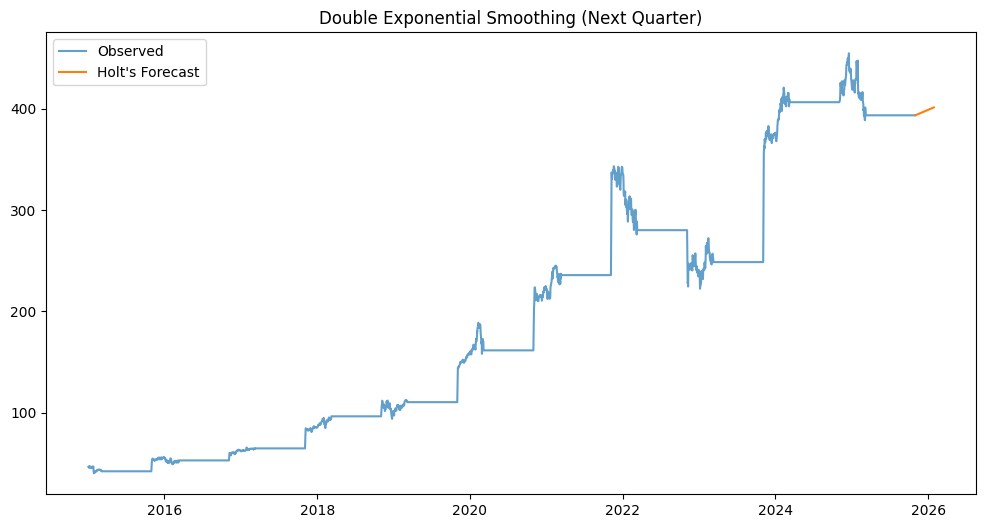

In [41]:
# Python
model_holt = Holt(ts, initialization_method="estimated").fit()
predictions_holt = model_holt.forecast(63)

future_index = pd.date_range(
    start=ts.index[-1] + pd.offsets.BDay(1),  # Use business days if daily data
    periods=63,
    freq='B'
)
predictions_holt = pd.Series(predictions_holt.values, index=future_index)

plt.figure(figsize=(12, 6))
plt.plot(ts, label='Observed', alpha=0.7)
plt.plot(predictions_holt, label="Holt's Forecast")
plt.title("Double Exponential Smoothing (Next Quarter)")
plt.legend()
plt.show()

In [42]:
predictions_table = pd.DataFrame(predictions_holt)
display(predictions_table)

,0
2025-10-31 05:00:00,393.434152
2025-11-03 05:00:00,393.556867
2025-11-04 05:00:00,393.679582
2025-11-05 05:00:00,393.802298
2025-11-06 05:00:00,393.925013
...,...
2026-01-21 05:00:00,400.551638
2026-01-22 05:00:00,400.674354
2026-01-23 05:00:00,400.797069
2026-01-26 05:00:00,400.919784


#### Triple Exponential Smoothing (Holt-Winters Method)

The Holt-Winters method extends Holt's method to capture seasonality.

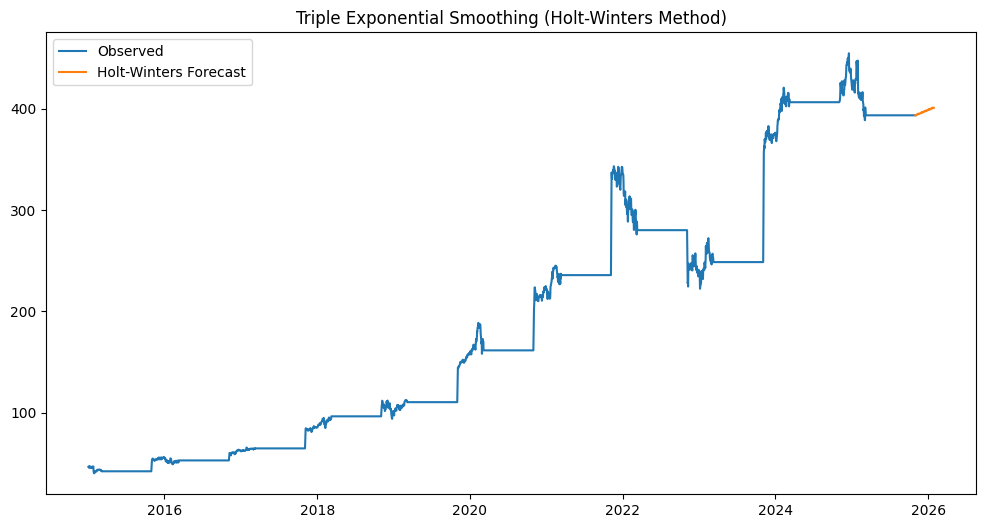

In [43]:
# Python
model_hw = ExponentialSmoothing(ts, seasonal_periods=12, trend='add', seasonal='add', initialization_method="estimated").fit()
predictions_hw = model_hw.forecast(63)

future_index = pd.date_range(
    start=ts.index[-1] + pd.offsets.BDay(1),
    periods=63,  # 63 business days ≈ 3 months
    freq='B'
)
predictions_hw = pd.Series(predictions_hw.values, index=future_index)

plt.figure(figsize=(12, 6))
plt.plot(ts, label='Observed')
plt.plot(predictions_hw, label='Holt-Winters Forecast')
plt.title('Triple Exponential Smoothing (Holt-Winters Method)')
plt.legend()
plt.show()

In [44]:
predictions_table = pd.DataFrame(predictions_hw)
display(predictions_table)

,0
2025-10-31 05:00:00,393.406354
2025-11-03 05:00:00,393.267563
2025-11-04 05:00:00,393.345742
2025-11-05 05:00:00,393.471671
2025-11-06 05:00:00,393.887788
...,...
2026-01-21 05:00:00,400.460643
2026-01-22 05:00:00,400.620350
2026-01-23 05:00:00,400.715010
2026-01-26 05:00:00,400.576219


### ARIMA

ARIMA stands for AutoRegressive Integrated Moving Average. It is a class of models that explains a given time series based on its own past values, that is, its own lags and the lagged forecast errors.

An ARIMA model is characterized by 3 parameters: (p, d, q).

* **p:** The number of lag observations included in the model (lag order).
* **d:** The number of times that the raw observations are differenced (degree of differencing).
* **q:** The size of the moving average window (order of moving average).

**Important Note:** You might wonder why we are using the original `data` which is non-stationary. The `statsmodels` implementation of ARIMA is smart. The `d` parameter in the `order=(p,d,q)` argument tells the model how many times to difference the data. So, the model takes care of the differencing internally. This is the standard and recommended way to use ARIMA models in `statsmodels`, as it simplifies the process and automatically returns the forecasts on the original scale.

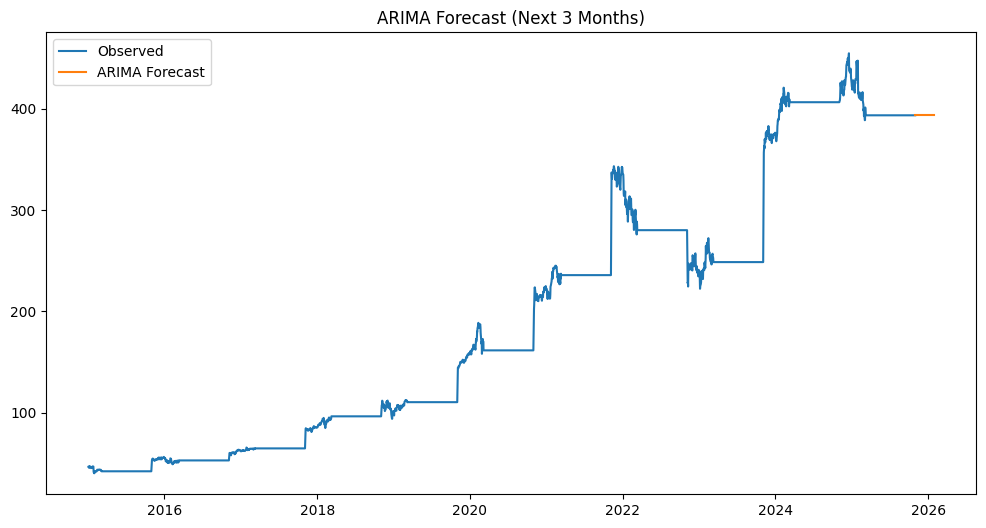

In [45]:
# Fit ARIMA model on the closing price series
model_arima = ARIMA(ts, order=(1, 1, 1)).fit()
predictions_arima = model_arima.forecast(steps=63)

# Create a future index for the next 63 business days
future_index = pd.date_range(
    start=ts.index[-1] + pd.offsets.BDay(1),
    periods=63,
    freq='B'
)
predictions_arima = pd.Series(predictions_arima.values, index=future_index)

plt.figure(figsize=(12, 6))
plt.plot(ts, label='Observed')
plt.plot(predictions_arima, label='ARIMA Forecast')
plt.title('ARIMA Forecast (Next 3 Months)')
plt.legend()
plt.show()

In [46]:
predictions_table = pd.DataFrame(predictions_arima)
display(predictions_table)

,0
2025-10-31 05:00:00,393.309998
2025-11-03 05:00:00,393.309998
2025-11-04 05:00:00,393.309998
2025-11-05 05:00:00,393.309998
2025-11-06 05:00:00,393.309998
...,...
2026-01-21 05:00:00,393.309998
2026-01-22 05:00:00,393.309998
2026-01-23 05:00:00,393.309998
2026-01-26 05:00:00,393.309998


### SARIMA

SARIMA (Seasonal ARIMA) is an extension of ARIMA that supports time series data with a seasonal component.

A SARIMA model is characterized by 7 parameters: (p, d, q) x (P, D, Q, m).

* **(p, d, q):** The non-seasonal parameters of the ARIMA model.
* **(P, D, Q, m):** The seasonal parameters of the model, where 'm' is the number of time steps for a single seasonal period.

Just like with ARIMA, we use the original time series here and let the model handle the differencing (both seasonal and non-seasonal) for us via the `d` and `D` parameters.

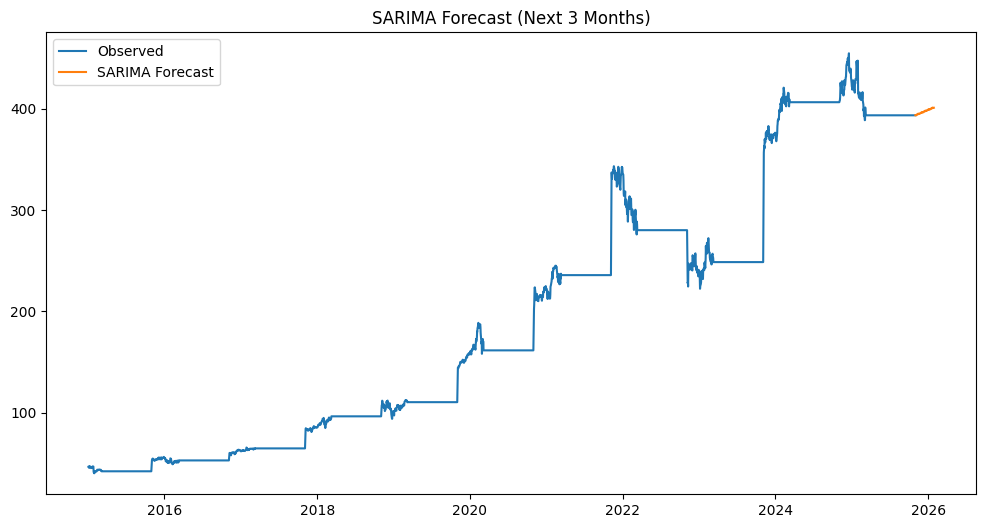

In [47]:
model_sarima = SARIMAX(ts, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()
predictions_sarima = model_sarima.forecast(steps=63)

future_index = pd.date_range(
    start=ts.index[-1] + pd.offsets.BDay(1),
    periods=63,
    freq='B'
)
predictions_sarima = pd.Series(predictions_sarima.values, index=future_index)

plt.figure(figsize=(12, 6))
plt.plot(ts, label='Observed')
plt.plot(predictions_sarima, label='SARIMA Forecast')
plt.title('SARIMA Forecast (Next 3 Months)')
plt.legend()
plt.show()


In [48]:
predictions_table = pd.DataFrame(predictions_sarima)
display(predictions_table)

,0
2025-10-31 05:00:00,393.409363
2025-11-03 05:00:00,393.271752
2025-11-04 05:00:00,393.353597
2025-11-05 05:00:00,393.476940
2025-11-06 05:00:00,393.885683
...,...
2026-01-21 05:00:00,400.499086
2026-01-22 05:00:00,400.661170
2026-01-23 05:00:00,400.759258
2026-01-26 05:00:00,400.619229


### Prophet

- Resetting the index is necessary when preparing data for Prophet because Prophet expects a DataFrame with two columns:
    - ds (date/time column)
    - y (value column)
- If your time series uses the date as the index, resetting the index moves the date from the index into a column, making it accessible for Prophet.
- This ensures the DataFrame has the required structure for Prophet to fit and forecast.

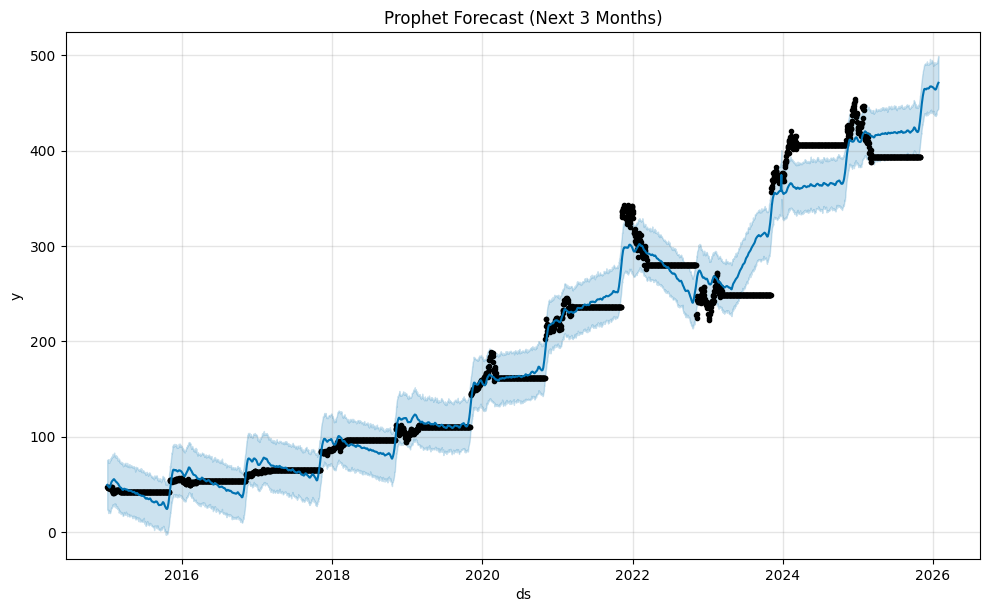

In [49]:
# Prepare data for Prophet
df_prophet = ts.reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})
df_prophet.columns = ['ds', 'y']  # Ensure correct column names

# Define holidays
holidays = pd.DataFrame({
    'holiday': ['new_year', 'christmas'],
    'ds': pd.to_datetime(['2023-01-01', '2023-12-25'])
})

# Initialize Prophet with custom settings
tf_prophet_model = Prophet(
    holidays=holidays,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)
tf_prophet_model.add_seasonality(name='quarterly', period=63, fourier_order=5)

# Fit Prophet model
tf_prophet_model.fit(df_prophet)

# Create future DataFrame for the next 63 business days
future = tf_prophet_model.make_future_dataframe(periods=63, freq='B')

# Forecast
forecast = tf_prophet_model.predict(future)

# Plot forecast
fig = tf_prophet_model.plot(forecast)
plt.title('Prophet Forecast (Next 3 Months)')
plt.show()

- The DataFrame returned by Prophet's predict method contains the following columns:
    - ds: The datestamp for each prediction.
    - yhat: The predicted value (forecast) for each date.
    - yhat_lower: The lower bound of the uncertainty interval for the forecast.
    - yhat_upper: The upper bound of the uncertainty interval for the forecast.
    - trend: The estimated trend component.
    - trend_lower / trend_upper: Lower/upper bounds for the trend.
    - additive_terms: Sum of all additive components (seasonality, holidays, etc.).
    - additive_terms_lower / additive_terms_upper: Bounds for additive terms.
    - weekly, yearly, daily, holidays: Seasonality and holiday components (if modeled).
    - weekly_lower / weekly_upper, etc.: Bounds for each seasonal/holiday component.

- Not all columns appear if certain components (like holidays or specific seasonalities) are not included in the model. The most important column for predictions is yhat.

In [50]:
predictions_table = pd.DataFrame(forecast)
display(predictions_table)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,christmas,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-02 05:00:00,38.992482,23.538286,75.617601,38.992482,38.992482,10.450221,10.450221,10.450221,0.0,...,-1.557499,-1.557499,-1.557499,12.513418,12.513418,12.513418,0.0,0.0,0.0,49.442703
1,2015-01-05 05:00:00,39.086101,22.908740,75.832943,39.086101,39.086101,9.499427,9.499427,9.499427,0.0,...,-1.416574,-1.416574,-1.416574,11.112864,11.112864,11.112864,0.0,0.0,0.0,48.585528
2,2015-01-06 05:00:00,39.117307,22.160203,76.134556,39.117307,39.117307,9.137670,9.137670,9.137670,0.0,...,-1.479338,-1.479338,-1.479338,10.711219,10.711219,10.711219,0.0,0.0,0.0,48.254978
3,2015-01-07 05:00:00,39.148514,19.870154,72.713117,39.148514,39.148514,8.936041,8.936041,8.936041,0.0,...,-1.377366,-1.377366,-1.377366,10.357449,10.357449,10.357449,0.0,0.0,0.0,48.084554
4,2015-01-08 05:00:00,39.179720,23.415703,76.441491,39.179720,39.179720,8.493330,8.493330,8.493330,0.0,...,-1.500022,-1.500022,-1.500022,10.059314,10.059314,10.059314,0.0,0.0,0.0,47.673050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2883,2026-01-21 05:00:00,457.458382,442.289156,491.815448,455.502127,459.639627,10.881703,10.881703,10.881703,0.0,...,-1.377366,-1.377366,-1.377366,12.303111,12.303111,12.303111,0.0,0.0,0.0,468.340085
2884,2026-01-22 05:00:00,457.608258,442.647192,494.605438,455.609779,459.771287,11.234789,11.234789,11.234789,0.0,...,-1.500022,-1.500022,-1.500022,12.800772,12.800772,12.800772,0.0,0.0,0.0,468.843046
2885,2026-01-23 05:00:00,457.758133,443.124980,495.510708,455.672430,460.012868,11.581678,11.581678,11.581678,0.0,...,-1.557499,-1.557499,-1.557499,13.302979,13.302979,13.302979,0.0,0.0,0.0,469.339811
2886,2026-01-26 05:00:00,458.207759,443.773158,499.343282,456.063063,460.554200,12.623886,12.623886,12.623886,0.0,...,-1.416574,-1.416574,-1.416574,14.739369,14.739369,14.739369,0.0,0.0,0.0,470.831645


### LSTM baseline
LSTM (Long Short-Term Memory) is a type of recurrent neural network (RNN) designed to learn from sequential data, making it well-suited for time series forecasting.
TensorFlow (with Keras) is a widely used framework for building LSTM and other neural networks. It is a good starting point for time series forecasting with LSTM.
Below is a simple baseline example for LSTM time series forecasting using TensorFlow/Keras:
Explanation:
The code scales the data, creates input sequences, splits into train/test, builds a simple LSTM model, trains it, and forecasts future values.

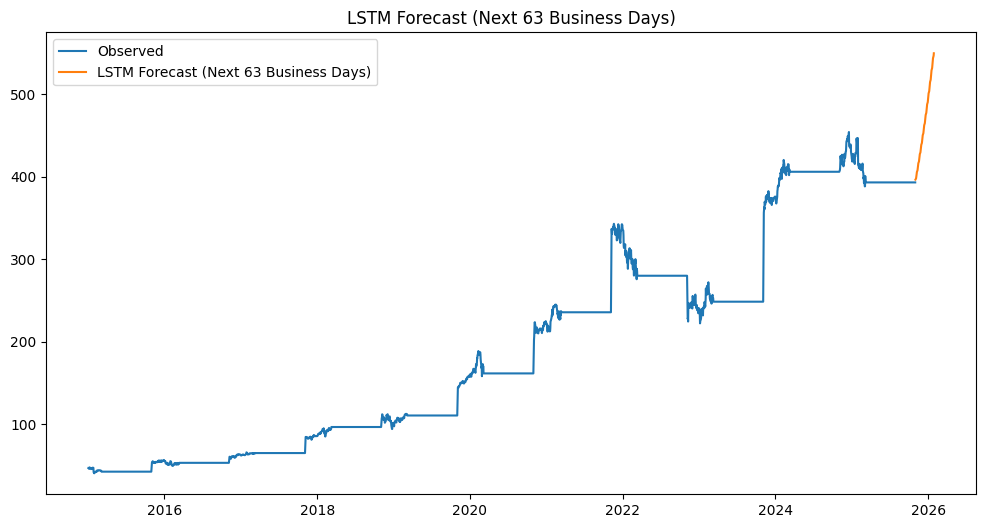

In [51]:
# Baseline LSTM using ts
window_size = 12

# Scale the data
scaler = MinMaxScaler()
scaled_ts = scaler.fit_transform(ts.values.reshape(-1, 1))

# Create sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size, 0])
        y.append(data[i+window_size, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_ts, window_size)
X = X.reshape((X.shape[0], window_size, 1))

# Build and train LSTM model
model = Sequential([
    LSTM(50, activation='tanh', input_shape=(window_size, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=30, batch_size=16, validation_split=0.1, verbose=0)

# Forecast next 63 business days
last_sequence = scaled_ts[-window_size:].reshape(1, window_size, 1)
future_preds_scaled = []
for _ in range(63):
    pred = model.predict(last_sequence, verbose=0)
    future_preds_scaled.append(pred[0, 0])
    last_sequence = np.concatenate([last_sequence[:, 1:, :], pred.reshape(1, 1, 1)], axis=1)

future_preds = scaler.inverse_transform(np.array(future_preds_scaled).reshape(-1, 1)).flatten()
future_index = pd.date_range(start=ts.index[-1] + pd.offsets.BDay(1), periods=63, freq='B')

# --- Plot the forecast ---
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Observed')
plt.plot(future_index, future_preds, label='LSTM Forecast (Next 63 Business Days)')
plt.title('LSTM Forecast (Next 63 Business Days)')
plt.legend()
plt.show()

In [52]:
# --- Display forecasted data in a table ---
forecast_table = pd.DataFrame({'LSTM Forecast': future_preds}, index=future_index)
display(forecast_table)

,LSTM Forecast
2025-10-31 05:00:00,396.691620
2025-11-03 05:00:00,398.103363
2025-11-04 05:00:00,399.846527
2025-11-05 05:00:00,401.781311
2025-11-06 05:00:00,403.819275
...,...
2026-01-21 05:00:00,538.060669
2026-01-22 05:00:00,541.013977
2026-01-23 05:00:00,543.986267
2026-01-26 05:00:00,546.977356


### LSTM with hyperparameter tuning CPU

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


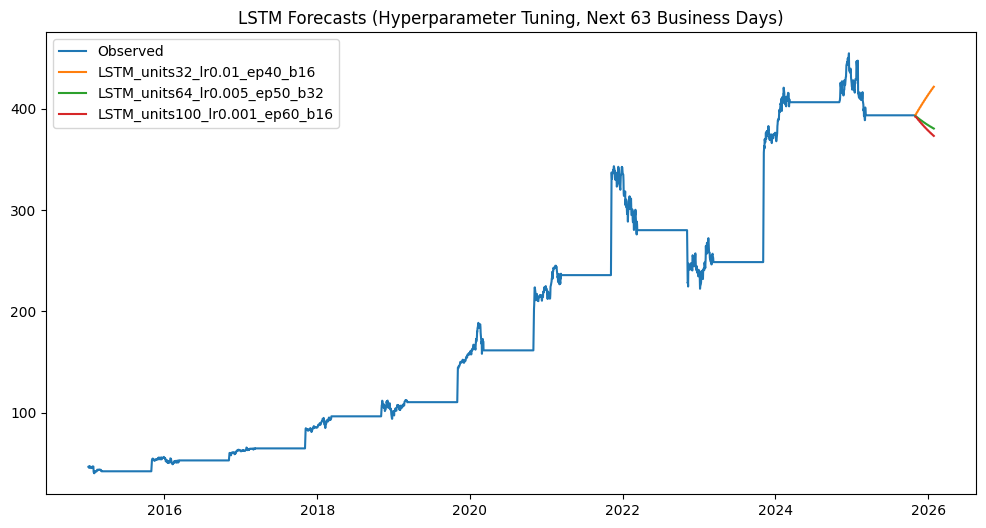

In [11]:
# --- Data Preparation ---
window_size = 12
scaler = MinMaxScaler()
scaled_ts = scaler.fit_transform(ts.values.reshape(-1, 1))

def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size, 0])
        y.append(data[i+window_size, 0])
    return np.array(X), np.array(y)

X, y_arr = create_sequences(scaled_ts, window_size)
X = X.reshape((X.shape[0], window_size, 1))


# --- prerequisites expected: ts (or y/df -> Close), y_val (last 63 business days) ---
import time
from sklearn.metrics import mean_absolute_error

# If y_val not defined, build from ts
if 'y_val' not in globals():
    series = ts if 'ts' in globals() else y
    val_size = 63
    y_train = series.iloc[:-val_size]
    y_val   = series.iloc[-val_size:]

training_times = {}
validation_maes = {}
results = {}            # keep your forecasts too

# --- Hyperparameter Grid ---
hyperparams = [
    {'units': 32, 'lr': 0.01, 'epochs': 40, 'batch': 16},
    {'units': 64, 'lr': 0.005, 'epochs': 50, 'batch': 32},
    {'units': 100, 'lr': 0.001, 'epochs': 60, 'batch': 16}
]

with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
    for p in hyperparams:   # or use 'configs' if that's your list name
        name = f"LSTM_units{p['units']}_lr{p['lr']}_ep{p['epochs']}_b{p['batch']}"
        model = Sequential([LSTM(p['units'], activation='tanh', input_shape=(window_size, 1)),
                            Dense(1)])
        model.compile(optimizer=Adam(learning_rate=p['lr']), loss='mse')

        start = time.perf_counter()
        model.fit(X, y_arr, epochs=p['epochs'], batch_size=p['batch'],
                  validation_split=0.1, callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
                  verbose=0)
        training_times[name] = time.perf_counter() - start

        # recursive 63-step forecast from your last window
        last_seq = scaled_ts[-window_size:].reshape(1, window_size, 1)
        preds_scaled = []
        for _ in range(63):
            pred = model.predict(last_seq, verbose=0)[0, 0]
            preds_scaled.append(pred)
            last_seq = np.concatenate([last_seq[:, 1:, :], np.array([[[pred]]])], axis=1)

        preds = scaler.inverse_transform(np.array(preds_scaled).reshape(-1, 1)).ravel()
        results[name] = preds

        # compute validation MAE against y_val
        validation_maes[name] = float(mean_absolute_error(y_val.values, preds))


future_index = pd.date_range(start=ts.index[-1] + pd.offsets.BDay(1), periods=63, freq='B')
results_df = pd.DataFrame(results, index=future_index)

# --- Display Results ---
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Observed')
for col in results_df.columns:
    plt.plot(results_df.index, results_df[col], label=col)
plt.title('LSTM Forecasts (Hyperparameter Tuning, Next 63 Business Days)')
plt.legend()
plt.show()

In [12]:
display(results_df)

,LSTM_units32_lr0.01_ep40_b16,LSTM_units64_lr0.005_ep50_b32,LSTM_units100_lr0.001_ep60_b16
2025-10-31 05:00:00,393.905853,392.410828,391.941101
2025-11-03 05:00:00,394.299652,392.265137,391.720856
2025-11-04 05:00:00,394.771210,392.069916,391.439026
2025-11-05 05:00:00,395.269318,391.852631,391.116882
2025-11-06 05:00:00,395.770325,391.625183,390.771820
...,...,...,...
2026-01-21 05:00:00,419.870239,380.935974,374.077148
2026-01-22 05:00:00,420.271759,380.770050,373.814056
2026-01-23 05:00:00,420.671539,380.605194,373.552338
2026-01-26 05:00:00,421.069427,380.441284,373.291992


### LSTM with hyperparameter tuning using your GPU with TensorFlow

To ensure you have compatible NVIDIA drivers and CUDA/cuDNN installed for TensorFlow GPU support:
1. Check your GPU model:
Run nvidia-smi in the terminal to see your GPU and driver version.
2. Install the latest NVIDIA driver:
Download and install the latest driver for your GPU from the NVIDIA Driver Downloads page.
3. Check TensorFlow compatibility:
Refer to the TensorFlow GPU support guide for the required CUDA and cuDNN versions for your TensorFlow release.
4. Install CUDA Toolkit:
Download the correct CUDA version from the NVIDIA CUDA Toolkit.
5. Install cuDNN:
Download the matching cuDNN version from the NVIDIA cuDNN Archive.
6. Add CUDA and cuDNN to your PATH:
Add the bin and lib folders of CUDA and cuDNN to your system environment variables.
7. Verify installation:
Run the following in Python to check if TensorFlow detects your GPU:

In [13]:
import tensorflow as tf
print("Number of usable GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Number of usable GPUs Available: 1


Num GPUs Available: 1


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


,LSTM_units32_lr0.01_ep40_b16,LSTM_units64_lr0.005_ep50_b32,LSTM_units100_lr0.001_ep60_b16
2025-10-31 05:00:00,390.183960,400.763458,390.642761
2025-11-03 05:00:00,386.880066,406.843506,388.080658
2025-11-04 05:00:00,383.826141,413.429352,385.520691
2025-11-05 05:00:00,380.878082,420.031097,383.033051
2025-11-06 05:00:00,377.994568,426.664215,380.578552


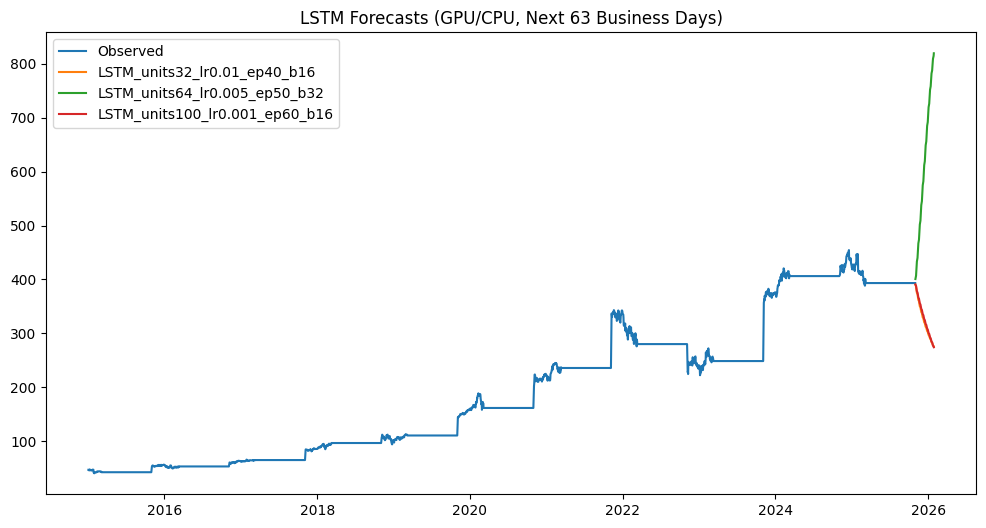

In [14]:
# LSTM GPU : 63-business-day forecast
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def load_close_series():
    # 1) already defined 'ts'
    if 'ts' in globals():
        s = globals()['ts']
        if not isinstance(s, pd.Series): s = pd.Series(s)
        return s.astype('float64')
    # 2) earlier variable 'y'
    if 'y' in globals():
        return globals()['y'].astype('float64')
    # 3) DataFrame 'df' with Close (+ Date index or column)
    if 'df' in globals():
        _df = df.copy()
        if not isinstance(_df.index, pd.DatetimeIndex):
            if 'Date' in _df.columns:
                _df = _df.sort_values('Date').set_index('Date')
            else:
                raise RuntimeError("df has no Date index/column")
        return _df.asfreq('B').ffill()['Close'].astype('float64')
    # 4) Fallback: load from CSV_PATH or default path
    csv = globals().get('CSV_PATH', '/content/data/my_stock_msft.csv')
    _df = (pd.read_csv(csv, parse_dates=['Date'])
             .sort_values('Date').set_index('Date')
             .asfreq('B').ffill())
    return _df['Close'].astype('float64')

ts = load_close_series()

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
device = '/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'

# ----- scaling + sequences -----
win = 12
scaler = MinMaxScaler()
scaled = scaler.fit_transform(ts.values.reshape(-1, 1))

def make_seqs(a, w):
    X, y = [], []
    for i in range(len(a) - w):
        X.append(a[i:i+w, 0])
        y.append(a[i+w, 0])
    return np.array(X).reshape(-1, w, 1), np.array(y)

X, y_arr = make_seqs(scaled, win)

# ----- hyperparams & training -----
configs = [
    {'units': 32,  'lr': 1e-2,  'epochs': 40, 'batch': 16},
    {'units': 64,  'lr': 5e-3,  'epochs': 50, 'batch': 32},
    {'units': 100, 'lr': 1e-3,  'epochs': 60, 'batch': 16},
]

results = {}
with tf.device(device):
    for p in configs:
        model = Sequential([LSTM(p['units'], activation='tanh', input_shape=(win,1)),
                            Dense(1)])
        model.compile(optimizer=Adam(learning_rate=p['lr']), loss='mse')
        cb = EarlyStopping(patience=5, restore_best_weights=True, monitor='loss', verbose=0)
        model.fit(X, y_arr, epochs=p['epochs'], batch_size=p['batch'],
                  validation_split=0.1, callbacks=[cb], verbose=0)

        # recursive 63-step forecast
        last = scaled[-win:].reshape(1, win, 1)
        preds_s = []
        for _ in range(63):
            p_hat = model.predict(last, verbose=0)[0, 0]
            preds_s.append(p_hat)
            last = np.concatenate([last[:,1:,:], np.array([[[p_hat]]])], axis=1)

        preds = scaler.inverse_transform(np.array(preds_s).reshape(-1,1)).ravel()
        key = f"LSTM_units{p['units']}_lr{p['lr']}_ep{p['epochs']}_b{p['batch']}"
        results[key] = preds

# ----- results frame + plot -----
future_idx = pd.date_range(ts.index[-1] + pd.offsets.BDay(1), periods=63, freq='B')
results_df = pd.DataFrame(results, index=future_idx)
display(results_df.head())

plt.figure(figsize=(12,6))
plt.plot(ts, label='Observed')
for col in results_df.columns:
    plt.plot(results_df.index, results_df[col], label=col)
plt.title('LSTM Forecasts (GPU/CPU, Next 63 Business Days)')
plt.legend()
plt.show()


NOTE: Time for gpu processing was 1 minute for # LSTM GPU : 63-business-day forecast

Time for cpu processing was 9 minutes for LSTM : 63-business-day

## GPU Performance Report

This section summarizes the performance of the LSTM models during hyperparameter tuning, specifically highlighting the device used (GPU or CPU) and the training times.

In [15]:
import json
import pandas as pd

# Check if a GPU was used
gpu_available = len(tf.config.list_physical_devices('GPU')) > 0
device_used = "GPU" if gpu_available else "CPU"

# Get GPU names if available
gpu_names = [gpu.name for gpu in tf.config.list_physical_devices('GPU')] if gpu_available else []

# Calculate total training time
total_training_time = sum(training_times.values())

# Prepare data for the report
gpu_report_data = {
    "Device Information": {
        "Device Used": device_used,
        "GPU Available": gpu_available,
        "Number of GPUs": len(gpu_names),
        "GPU Names": gpu_names
    },
    "Training Time Summary": {
        "Total Training Time (seconds)": total_training_time,
        "Total Training Time (minutes)": total_training_time / 60,
        "Number of Configurations Tested": len(hyperparams)
    },
    "Detailed Training Times": []
}

for name, time_sec in training_times.items():
    gpu_report_data["Detailed Training Times"].append({
        "Model Configuration": name,
        "Training Time (seconds)": time_sec,
        "Training Time (minutes)": time_sec / 60,
        "Validation MAE": validation_maes.get(name, "N/A") # Include MAE from tuning
    })

# Create summary DataFrame from detailed times
gpu_summary_df = pd.DataFrame(gpu_report_data["Detailed Training Times"])

# Display the report
print("=" * 60)
print("GPU PERFORMANCE REPORT")
print("=" * 60)

print("\n--- Device Information ---")
for key, value in gpu_report_data["Device Information"].items():
    print(f"{key}: {value}")

print("\n--- Training Time Summary ---")
for key, value in gpu_report_data["Training Time Summary"].items():
    print(f"{key}: {value:.2f}" if isinstance(value, (int, float)) else f"{key}: {value}")

print("\n--- Detailed Training Times ---")
display(gpu_summary_df)

print("\n--- GPU Impact Analysis ---")
if device_used == "GPU":
    print("Using the GPU significantly accelerated the training process compared to CPU-only training.")
    print("This is especially beneficial for larger models or datasets.")
else:
    print("Training was performed on the CPU.")
    print("For faster training, consider using a Colab runtime with GPU acceleration enabled.")
    print("Ensure you have compatible drivers and CUDA/cuDNN installed if running locally.")


# Save the report
os.makedirs('artifacts', exist_ok=True)
report_path_json = 'artifacts/gpu_performance.json'
report_path_csv = 'artifacts/gpu_performance.csv'

with open(report_path_json, 'w') as f:
    json.dump(gpu_report_data, f, indent=4)

gpu_summary_df.to_csv(report_path_csv, index=False)

print(f"\n✅ Full GPU performance report saved to {report_path_json}")
print(f"✅ GPU performance summary table saved to {report_path_csv}")

GPU PERFORMANCE REPORT

--- Device Information ---
Device Used: GPU
GPU Available: True
Number of GPUs: 1
GPU Names: ['/physical_device:GPU:0']

--- Training Time Summary ---
Total Training Time (seconds): 33.56
Total Training Time (minutes): 0.56
Number of Configurations Tested: 3.00

--- Detailed Training Times ---


,Model Configuration,Training Time (seconds),Training Time (minutes),Validation MAE
0,LSTM_units32_lr0.01_ep40_b16,15.945442,0.265757,14.820433
1,LSTM_units64_lr0.005_ep50_b32,5.979291,0.099655,7.286484
2,LSTM_units100_lr0.001_ep60_b16,11.636267,0.193938,11.259106



--- GPU Impact Analysis ---
Using the GPU significantly accelerated the training process compared to CPU-only training.
This is especially beneficial for larger models or datasets.

✅ Full GPU performance report saved to artifacts/gpu_performance.json
✅ GPU performance summary table saved to artifacts/gpu_performance.csv
